#LAB 4: Semantic segmentation

<h4><div style="text-align: right"> Due date: 15:00 Nov 18, 2024.  </div> <br>
<div style="text-align: right"> Please upload your file and final-report at PLATO before the class in the form of [ID_Name_Lab1.ipynb]. </div></h4>


### *Instructions:*
- Write a program implementing a particular algorithm to solve a given problem.   
- <span style="color:red">**Report and discuss your results. Analyze the algorithm, theoretically and empirically.**</span>
- You must write their own answers and codes (<span style="color:red">**if not you will get a F grade**</span>).


<h2><span style="color:blue">[202055623] [허치영]</span> </h2>

In [1]:
import datetime
print("This code is written at " + str(datetime.datetime.now()))

This code is written at 2024-11-18 14:22:51.380681


In [2]:
import cv2
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.models as models

In [3]:
import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" # Arrange GPU devices starting from 0 
os.environ["CUDA_VISIBLE_DEVICES"]= "3" # Set the GPU 3 to use

In [4]:
import random
# Set the random seed for reproducibility
seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print("Random seed set to:", seed)

Random seed set to: 0


In [5]:
import sys
import platform

print("Python version")
print(sys.version_info)

print("\nOS information")
print(platform.platform())

print("\nIs GPU available?")
print(torch.cuda.is_available())

# print("\nCPU information")
# !cat /proc/cpuinfo

# print("\nMemory information")
# !cat /proc/meminfo

if torch.cuda.is_available():
    print("\nGPU information")
    !nvidia-smi
    device = torch.device('cuda')
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print(f"\ndevice={device}")
# os.chdir('/home/dlpro24/24-2DLProgramming/huch0')
print(os.getcwd())

Python version
sys.version_info(major=3, minor=8, micro=19, releaselevel='final', serial=0)

OS information
Linux-5.4.0-193-generic-x86_64-with-glibc2.17

Is GPU available?
True

GPU information
Mon Nov 18 14:22:53 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A5000               On  | 00000000:01:00.0 Off |                  Off |
| 30%   32C    P8              16W / 230W |  24235MiB




## Introduction


### What is Semantic Segmentation?
#### Semantic segmentation is an approach to understand what is in the image in pixel-level:

- It is a lot more difficult than image classification, which makes a prediction in image-level.

- It differs from object detection in that it has no information about instances.

<img src="https://drive.google.com/uc?export=view&id=1Oe6OVIuT8WPxK4x0LXOunxL-tVtzg948" alt="no_image" style="width: 900px;"/>

Applications for semantic segmentation include:

- Autonomous driving

- Image Editing

- Classification of terrain visible in satellite imagery

- Medical imaging analysis

### 1. Semantic segmentation with CNNs
- Typical classification models (AlexNet, VGGNet, ...) take fixed-sized inputs and produce a probability vector. The fully connected layers of these models have fixed dimensions and throw away spatial coordinates.


- It is known that the fully connected layer can be viewed as a convolution layer with a kernel that covers only one pixel, that is, a 1x1 kernel. Thus, we can convert the fully connected layers into convolution layers with maintaining pre-trained weights.


- After 'convolutionalizing' fully connected layers, a feature map needs to be upsampled because of pooling operations in the models. Instead of using simple bilinear interpolation, we can use a transposed convolution layer to learn the interpolation process. This layer is also called as upconvolution, deconvolution or fractionally-strided convolution.

### 1.1 Pixel wise classification using sliding window

<img src="https://drive.google.com/uc?export=view&id=1RJOmD22NyRT-6T0hCQ5hbU3FB9Mpevyu" alt="no_image" style="width: 900px;"/>

### 1.1.1 Example with VGG-Net

**Load a test image**

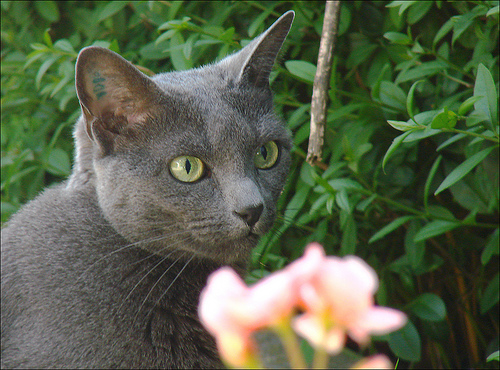

In [6]:
from PIL import Image
test_img_path = 'lab4/img/2009_005160.jpg'
test_img = Image.open(test_img_path)
test_img

**Standardization of the test image**

In [7]:
import torchvision.transforms as transforms
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])

# test_transform = transform(test_img).cuda().unsqueeze(0)
test_transform = transform(test_img).to(device).unsqueeze(0)
print(test_transform.size())

torch.Size([1, 3, 224, 224])


**Load VGG-Net**

In [8]:
import torchvision.models.vgg as vgg
# imageNet = vgg.vgg16(pretrained=True).cuda()
imageNet = vgg.vgg16(pretrained=True).to(device)

/home/team104/miniconda3/envs/huch0-venv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/team104/miniconda3/envs/huch0-venv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
import torch
import torch.nn as nn
with torch.no_grad():
    out = imageNet(test_transform)

out_class = torch.argmax(out)
print(out.size())
print(out_class) # 285 is egyptian cat in ImageNet

torch.Size([1, 1000])
tensor(285, device='cuda:0')


In [10]:
# padding
m = nn.ZeroPad2d((111,112,111,112))
pad_image = m(test_transform)
# res = torch.zeros((224,224)).cuda()
res = torch.zeros((224,224)).to(device)

In [11]:
# sliding window approach for segmentation
# NOTICE: It takes some time
for i in range(224):
    for j in range(224):
        patch = pad_image[:,:,i:i+224,j:j+224]
        # classify each pixels
        with torch.no_grad():
            res[i,j] = torch.argmax(imageNet(patch))

In [12]:
print(res)

tensor([[285., 285., 285.,  ...,  24.,  24., 285.],
        [285., 285., 285.,  ..., 281., 285., 285.],
        [285., 285., 285.,  ..., 282., 285.,  24.],
        ...,
        [284., 286., 298.,  ..., 285., 254., 254.],
        [360., 286., 360.,  ..., 280., 254., 265.],
        [284., 298., 285.,  ..., 254., 254., 254.]], device='cuda:0')


**Visualize the output, classified as 'egyptian cat' (285)**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


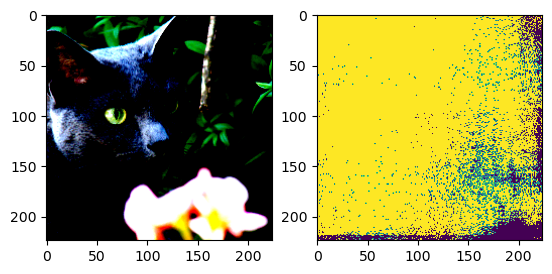

In [13]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.subplot(1,2,1)
plt.imshow(test_transform[0].data.cpu().numpy().transpose((1,2,0)))
plt.subplot(1,2,2)
plt.imshow((res==285).data.cpu().numpy()) # Visualize pixels classified as egyptian cat
plt.show()

- Inefficient & Ineffective !

### 1.2 Pixel wise classification using image classification

<img src="https://drive.google.com/uc?export=view&id=1XaspEEpplLzpNJ8qJpPN24qMeVmbsp5P" alt="no_image" style="width: 900px;"/>

#### 1.2.1 Convolutional VGG

In [14]:
import torchvision.models as models

class ConvolutionalVGG(nn.Module):
    def __init__(self):
        super(ConvolutionalVGG, self).__init__()
        self.features = models.vgg16(pretrained=True).features

        # fc6
        self.fc6 = nn.Conv2d(512, 4096, 7)
        self.relu6 = nn.ReLU(inplace=True)
        self.drop6 = nn.Dropout2d()

        # fc7
        self.fc7 = nn.Conv2d(4096, 4096, 1)
        self.relu7 = nn.ReLU(inplace=True)
        self.drop7 = nn.Dropout2d()

        # fc8
        self.fc8 = nn.Conv2d(4096, 1000, 1)

        self.copy_params_from_vgg16()

    def forward(self, x):
        conv5 = self.features(x)

        fc6 = self.relu6(self.fc6(conv5))
        fc7 = self.drop6(fc6)

        fc7 = self.relu7(self.fc7(fc7))
        fc8 = self.drop7(fc7)

        score = self.fc8(fc8)

        return score

    def copy_params_from_vgg16(self):
        vgg16 = models.vgg16(pretrained=True)
        for i, name in zip([0, 3, 6], ['fc6', 'fc7', 'fc8']):
            l1 = vgg16.classifier[i]
            l2 = getattr(self, name)
            l2.weight.data.copy_(l1.weight.data.view(l2.weight.size()))
            l2.bias.data.copy_(l1.bias.data.view(l2.bias.size()))

In [15]:
# conv_vgg = ConvolutionalVGG().cuda()
conv_vgg = ConvolutionalVGG().to(device)
conv_vgg

ConvolutionalVGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=

In [16]:
transform_conv = transforms.Compose([
    transforms.ToTensor(),
    normalize,
])

In [17]:
# test_conv = transform_conv(test_img).cuda().unsqueeze(0)
test_conv = transform_conv(test_img).to(device).unsqueeze(0)
print(test_conv.size())

torch.Size([1, 3, 370, 500])


In [18]:
conv_out = conv_vgg(test_conv)
pred = torch.argmax(conv_out, dim=1)
pred

tensor([[[285, 478, 478, 478, 287, 287, 287, 287, 287],
         [284, 284, 478, 478, 284, 285, 478, 285, 285],
         [285, 285, 284, 284, 284, 287, 287, 287, 287],
         [285, 285, 285, 284, 284, 287, 287, 287, 285],
         [285, 285, 285, 285, 285, 281, 852, 852, 285]]], device='cuda:0')

Well...

Although modifying VGG-Net to fully convolutional network results in a pixel-wise ouput, the output resolution is smaller than the original image resolution. Moreover, we can see that many pixels are misclassified (i.e., not 285).

#### 1.2.2 Add simple upsampling layer (Bilinear) and retrain with PASCAL VOC 2012  [1 point]
- Re-define the last layer so as to classify classes in the PASCAL VOC datasets
- Use bilinear interpolation to make the network output equal to the input size

In [40]:
import torchvision.models as models


class ConvolutionalVGGwithUpsample(nn.Module):
    def __init__(self):
        super(ConvolutionalVGGwithUpsample, self).__init__()
        self.features = models.vgg16(pretrained=True).features
        self.features[0].padding = (100, 100)

        # fc6
        self.fc6 = nn.Conv2d(512, 4096, 7)
        self.relu6 = nn.ReLU(inplace=True)
        self.drop6 = nn.Dropout2d()

        # fc7
        self.fc7 = nn.Conv2d(4096, 4096, 1)
        self.relu7 = nn.ReLU(inplace=True)
        self.drop7 = nn.Dropout2d()

        # fc8
        #############
        # CODE HERE #
        #############
        self.fc8 = nn.Conv2d(4096, 21, 1)

        self.copy_params_from_vgg16()

    def forward(self, x):
        conv5 = self.features(x)

        fc6 = self.relu6(self.fc6(conv5))
        fc7 = self.drop6(fc6)

        fc7 = self.relu7(self.fc7(fc7))
        fc8 = self.drop7(fc7)

        score = self.fc8(fc8)

        #############
        # CODE HERE #
        #############
        # Upsample to original resolution
        score = nn.functional.interpolate(score, size=(x.size(2), x.size(3)), mode='bilinear', align_corners=False)

        return score

    def copy_params_from_vgg16(self):
        vgg16 = models.vgg16(pretrained=True)
        for i, name in zip([0, 3], ['fc6', 'fc7']):
            l1 = vgg16.classifier[i]
            l2 = getattr(self, name)
            l2.weight.data.copy_(l1.weight.data.view(l2.weight.size()))
            l2.bias.data.copy_(l1.bias.data.view(l2.bias.size()))

In [41]:
# conv_vgg_upsample = ConvolutionalVGGwithUpsample().cuda()
conv_vgg_upsample = ConvolutionalVGGwithUpsample().to(device)

In [42]:
def decode_labels(mask, num_classes=21):
    from PIL import Image
    label_colours = [(0, 0, 0)
                 # 0=background
                 , (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128)
                 # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
                 , (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0)
                 # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
                 , (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128)
                 # 11=diningtable, 12=dog, 13=horse, 14=motorbike, 15=person
                 , (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)]
                 # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor

    h, w = mask.shape

    img = Image.new('RGB', (w, h))
    pixels = img.load()
    for j_, j in enumerate(mask[:, :]):
        for k_, k in enumerate(j):
            if k < num_classes:
                pixels[k_, j_] = label_colours[k]
    output = np.array(img)

    return output

In [43]:
model_data = torch.load('lab4/vgg_conv_upsample.pth')
conv_vgg_upsample.load_state_dict(model_data)
# conv_vgg_upsample = ConvolutionalVGGwithUpsample().to(device)

/tmp/ipykernel_1006810/2788461873.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_data = torch.load('lab4/vgg_conv_upsample.pth')


<All keys matched successfully>

In [60]:
with torch.no_grad():
    conv_out = conv_vgg_upsample(test_conv)
output = torch.argmax(conv_out, dim=1)

vis_output = decode_labels(output[0].data.cpu().numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


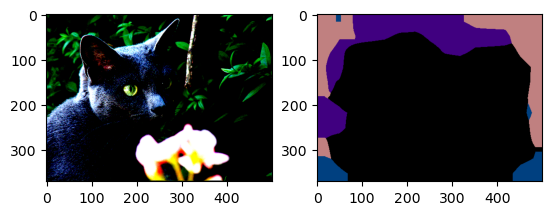

In [61]:
plt.subplot(1,2,1)
plt.imshow(test_conv[0].data.cpu().numpy().transpose((1,2,0)))
plt.subplot(1,2,2)
plt.imshow(vis_output)

### 1.3 Upsampling method with CNNs

#### 1.3.1 Transposed Convolution

<img src="https://drive.google.com/uc?export=view&id=1olTrk2Hu1dAppF2zxFVedy0aIrAbYrAw"  onerror="this.style.display='none'" /><br><br>

- The transposed convolution (it is often called as "deconvolution") is used to up-sample the input resolution by using learnable filters. In contrast to the standard convolution, which aggregates spatial information to a single point, it spreads a point of the input over multiple spatial locations.
- For example, a $3\times3$ kernel with a stride of 2 converts the~$2\times2$~(cyan squares) input into the~$5\times5$~(blue squares) output.

#### 1.3.2 Dilated Convolution
<img src="https://drive.google.com/uc?export=view&id=1LxBcf7V_s7559Odw9JzPwXFpPYCXa4JT"  onerror="this.style.display='none'" /><br><br>
- The dilated convolution introduces 'a dilation rate' to the standard convolution.

- The dilation rate means a spacing value between elements of a kernel, which enlarges the receptive field without introducing additional parameters.

- For example, a $3\times3$ kernel with a dilation rate of 2 has the same receptive field as a $5\times5$ kernel while it still use 9 parameters only, compared to the $5\times5$ the uses 25 parameters.

## 2. [Lab] Semantic segmentation

### 2.1 Write a FCN8s model  [4 points]

<img src="https://drive.google.com/uc?export=view&id=1xLdKvbMZrszjG2nVqFV3AsJ0t4M-nEN6"  onerror="this.style.display='none'" /><br><br>

<p style='text-align:right;'>[<a href='https://medium.com/@wilburdes/semantic-segmentation-using-fully-convolutional-neural-networks-86e45336f99b'>source</a>]</p>

**Crop boundary example**

In [62]:
a = torch.ones((1, 1, 160, 140))
b = torch.ones((1, 1, 120, 120))

try:
    a + b
except:
    print('The size of tensors are different')
    print(a.size())
    print(b.size())

# crop boundary
a = a[:, :, 5: 5+b.size(2), 5:5+b.size(3)]

# add connection with weight
c = 0.01*a + b
print(c.size())

The size of tensors are different
torch.Size([1, 1, 160, 140])
torch.Size([1, 1, 120, 120])
torch.Size([1, 1, 120, 120])


- Predict 1: $1\times1$ Conv(in: 4096, out: n_class)
- Predict 2: $1\times1$ Conv(in: 512, out: n_class), weight = 0.01
- Predict 3: $1\times1$ Conv(in: 256, out: n_class), weight = 0.0001

- Deconv 1: $4\times4$ Transposed Conv (in: n_class, out: n_class, stride: 2, biase: False)
- Deconv 2: $4\times4$ Transposed Conv (in: n_class, out: n_class, stride: 2, biase: False)
- Deconv 3: $16\times16$ Transposed Conv (in: n_class, out: n_class, stride: 8, biase: False)

In [63]:
class FCN8s(nn.Module):
    def __init__(self, n_class=21):
        super(FCN8s, self).__init__()
        # VGG features
        self.features = models.vgg16(pretrained=True).features

        # fc6
        self.fc6 = nn.Conv2d(512, 4096, 7)
        self.relu6 = nn.ReLU(inplace=True)
        self.drop6 = nn.Dropout2d()

        # fc7
        self.fc7 = nn.Conv2d(4096, 4096, 1)
        self.relu7 = nn.ReLU(inplace=True)
        self.drop7 = nn.Dropout2d()

        #############
        # CODE HERE #
        #############

        # Predict 1, 2, 3
        self.predict1 = nn.Conv2d(in_channels=4096, out_channels=n_class, kernel_size=1)
        self.predict2 = nn.Conv2d(in_channels=512, out_channels=n_class, kernel_size=1)
        self.predict3 = nn.Conv2d(in_channels=256, out_channels=n_class, kernel_size=1)

        # Deconv 1, 2, 3
        self.deconv1 = nn.ConvTranspose2d(in_channels=n_class, out_channels=n_class,
                                          kernel_size=4, stride=2, bias=False)
        self.deconv2 = nn.ConvTranspose2d(in_channels=n_class, out_channels=n_class,
                                          kernel_size=4, stride=2, bias=False)
        self.deconv3 = nn.ConvTranspose2d(in_channels=n_class, out_channels=n_class,
                                          kernel_size=16, stride=8, bias=False)

        self._initialize_weights()
        self.copy_params_from_vgg16()

    def _initialize_weights(self):
        self.features[0].padding = (100, 100)

        for m in self.modules():
            if isinstance(m, nn.MaxPool2d):
                m.ceil_mode = True
            if isinstance(m, nn.ConvTranspose2d):
                assert m.kernel_size[0] == m.kernel_size[1]
                initial_weight = get_upsampling_weight(
                    m.in_channels, m.out_channels, m.kernel_size[0])
                m.weight.data.copy_(initial_weight)

    def forward(self, x):
        #############
        # CODE HERE #
        #############

        # print(f"x.size()={x.size()}")
        input_size = x.size()

        # 16, 23
        feature_maps = []
        for i, layer in enumerate(self.features):
            x = layer(x)
            # print(f"{i}: {layer}, x.size()={x.size()}")
            if i in {16, 23}:
                feature_maps.append(x)

        # fc6
        x = self.drop6(self.relu6(self.fc6(x)))
        # print(f"fc6, x.size()={x.size()}")
        # fc7
        x = self.drop7(self.relu7(self.fc7(x)))
        # print(f"fc7, x.size()={x.size()}")

        # Predict 1, 2, 3
        pr1 = self.predict1(x)
        pr2 = self.predict2(feature_maps[1])
        pr3 = self.predict3(feature_maps[0])

        # print(f"predcit1: {pr1.size()}")
        # print(f"predcit2: {pr2.size()}")
        # print(f"predcit3: {pr3.size()}")

        # Deconv 1, 2, 3
        pr1 = self.deconv1(pr1)
        # print(f"deconv1: {pr1.size()}")
        start_h_pr2 = (pr2.size(2) - pr1.size(2)) // 2
        start_w_pr2 = (pr2.size(3) - pr1.size(3)) // 2
        pr2 = pr2[:, :, start_h_pr2:start_h_pr2 + pr1.size(2), start_w_pr2:start_w_pr2 + pr1.size(3)]
        upsample1 = pr1 + 0.01 * pr2
        # print(f"upsample1: {upsample1.size()}")

        upsample1 = self.deconv2(upsample1)
        start_h_pr3 = (pr3.size(2) - upsample1.size(2)) // 2
        start_w_pr3 = (pr3.size(3) - upsample1.size(3)) // 2
        pr3 = pr3[:, :, start_h_pr3:start_h_pr3 + upsample1.size(2), start_w_pr3:start_w_pr3 + upsample1.size(3)]
        upsample2 = upsample1 + 0.0001 * pr3
        # print(f"upsample2: {upsample2.size()}")

        upsample3 = self.deconv3(upsample2)
        # print(f"upsample3: {upsample3.size()}")

        # Crop the output to the size of the input
        start_h_upsample3 = (upsample3.size(2) - input_size[2]) // 2
        start_w_upsample3 = (upsample3.size(3) - input_size[3]) // 2
        output = upsample3[:, :, start_h_upsample3:start_h_upsample3 +
                           input_size[2], start_w_upsample3:start_w_upsample3 + input_size[3]]
        # print(f"output: {output.size()}")

        assert output.size()[2:] == input_size[2:], "Output dimensions do not match input dimensions."

        # print("*" * 50)
        return output

    def copy_params_from_vgg16(self):
        vgg16 = models.vgg16(pretrained=True)
        for i, name in zip([0, 3], ['fc6', 'fc7']):
            l1 = vgg16.classifier[i]
            l2 = getattr(self, name)
            l2.weight.data.copy_(l1.weight.data.view(l2.weight.size()))
            l2.bias.data.copy_(l1.bias.data.view(l2.bias.size()))


def get_upsampling_weight(in_channels, out_channels, kernel_size):
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:kernel_size, :kernel_size]
    filt = (1 - abs(og[0] - center) / factor) * \
           (1 - abs(og[1] - center) / factor)
    weight = np.zeros((in_channels, out_channels, kernel_size, kernel_size),
                      dtype=np.float64)
    weight[range(in_channels), range(out_channels), :, :] = filt
    return torch.from_numpy(weight).float()

In [64]:
# model = FCN8s().cuda()
model = FCN8s().to(device)

**Data Loader functions**

In [65]:
import random
import os

def read_file(path_to_file):
    with open(path_to_file) as f:
        img_list = []
        for line in f:
            img_list.append(line[:-1])
    return img_list

def chunker(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

def flip(I, flip_p):
    if flip_p > 0.5:
        return np.fliplr(I)
    else:
        return I

def scale_im(img_temp, scale):
    new_dims = (int(img_temp.shape[0] * scale), int(img_temp.shape[1] * scale))
    return cv2.resize(img_temp, new_dims).astype(float)


def get_data(chunk, gt_path='lab4/gt', img_path='lab4/img'):
    assert len(chunk) == 1

    scale = random.uniform(0.5, 1.3)
    flip_p = random.uniform(0, 1)

    images = cv2.imread(os.path.join(img_path, chunk[0] + '.jpg')).astype(float)

    images = cv2.resize(images, (321, 321)).astype(float)
    images = scale_im(images, scale)
    images[:, :, 0] = images[:, :, 0] - 104.008
    images[:, :, 1] = images[:, :, 1] - 116.669
    images[:, :, 2] = images[:, :, 2] - 122.675
    images = flip(images, flip_p)
    images = images[:, :, :, np.newaxis]
    images = images.transpose((3, 2, 0, 1))
    images = torch.from_numpy(images.copy()).float()

    gt = cv2.imread(os.path.join(gt_path, chunk[0] + '.png'))[:, :, 0]
    gt[gt == 255] = 0
    gt = flip(gt, flip_p)

    dim = int(321 * scale)

    gt = cv2.resize(gt, (dim, dim), interpolation=cv2.INTER_NEAREST).astype(float)

    labels = gt[np.newaxis, :].copy()

    return images, labels

**Data load**

In [66]:
img_list = read_file('lab4/list/train_aug.txt')
data_list = []

for i in range(10):
    np.random.shuffle(img_list)
    data_list.extend(img_list)
data_gen = chunker(data_list, 1)

print(data_gen.__class__)

<class 'generator'>


In [67]:
lr = 1e-4
# choose your lr

optimizer = optim.Adam(model.parameters(), lr=lr)
optimizer.zero_grad()
max_iter = 20000
accumulation_steps = 32

### 2.2 Write train code and print loss [2 points]
- Use a cross-entropy loss.
- Print a training loss for every 100 iterations.
- Show that the training loss steadily decreases.

In [68]:
import torch.nn.functional as F


def loss_calc(out, label):
    return F.cross_entropy(out, label, ignore_index=255, reduction='mean')

In [69]:
running_loss = 0.0
model.train()
optimizer.zero_grad()  # Zero gradients at the start

for iter in range(1, max_iter + 1):
    inputs, label = get_data(next(data_gen))

    # Move inputs and labels to the device
    inputs = inputs.to(device)
    label = torch.from_numpy(label).to(device).long()

    # Forward pass
    out = model(inputs)
    loss = loss_calc(out, label)  # Calculate the loss

    # Backpropagation
    loss.backward()  # Accumulate gradients without stepping the optimizer yet
    running_loss += loss.item()

    # Accumulate gradients and update every `accumulation_steps` iterations
    if iter % accumulation_steps == 0:
        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        
        # Optimizer step and reset gradients
        optimizer.step()
        optimizer.zero_grad()

    if iter % 100 == 0:
        mean_loss = running_loss / 100
        print(f'Iter: {iter:5d}, Mean Loss: {mean_loss:.4f}')

        running_loss = 0.0

    # Display live progress
    percentage = (iter / max_iter) * 100
    print(f"{percentage:.2f}% - Current loss: {loss.item():2.4f}", end='\r')

print("\nTraining complete.")

Iter:   100, Mean Loss: 4.1175
Iter:   200, Mean Loss: 1.6308
Iter:   300, Mean Loss: 1.4509
Iter:   400, Mean Loss: 1.3355
Iter:   500, Mean Loss: 1.2569
Iter:   600, Mean Loss: 1.6118
Iter:   700, Mean Loss: 1.3013
Iter:   800, Mean Loss: 1.2748
Iter:   900, Mean Loss: 1.1756
Iter:  1000, Mean Loss: 1.2112
Iter:  1100, Mean Loss: 1.2237
Iter:  1200, Mean Loss: 1.0805
Iter:  1300, Mean Loss: 1.1011
Iter:  1400, Mean Loss: 0.9739
Iter:  1500, Mean Loss: 1.0506
Iter:  1600, Mean Loss: 1.0281
Iter:  1700, Mean Loss: 0.8908
Iter:  1800, Mean Loss: 1.0595
Iter:  1900, Mean Loss: 0.9537
Iter:  2000, Mean Loss: 0.9467
Iter:  2100, Mean Loss: 1.0123
Iter:  2200, Mean Loss: 1.0430
Iter:  2300, Mean Loss: 0.9710
Iter:  2400, Mean Loss: 0.9815
Iter:  2500, Mean Loss: 0.9070
Iter:  2600, Mean Loss: 0.8562
Iter:  2700, Mean Loss: 0.8653
Iter:  2800, Mean Loss: 0.8634
Iter:  2900, Mean Loss: 0.7634
Iter:  3000, Mean Loss: 0.8055
Iter:  3100, Mean Loss: 0.8503
Iter:  3200, Mean Loss: 0.9010
Iter:  3

### 2.3 Discuss the result [3 points]
- Compare and Discuss the results. Note that it must contain the quantitative and qualitative results.
- Use the below 'validation_miou' function to evaluate your model. Your model should perform better than the example model **(0.5 mIoU)**.
- Use the above 'decode_label' function to visualize the network output.

In [70]:
def validation_miou(model):
    max_label = 20
    hist = np.zeros((max_label + 1, max_label + 1))

    def fast_hist(a, b, n):
        k = (a >= 0) & (a < n)
        return np.bincount(n * a[k].astype(int) + b[k], minlength=n ** 2).reshape(n, n)

    val_list = open('lab4/list/val.txt').readlines()

    with torch.no_grad():
        for idx, i in enumerate(val_list):
            print('{}/{} ...'.format(idx + 1, len(val_list)), end='\r')

            img = cv2.imread(os.path.join('lab4/img', i[:-1] + '.jpg')).astype(float)

            img[:, :, 0] -= 104.008
            img[:, :, 1] -= 116.669
            img[:, :, 2] -= 122.675

            data = torch.from_numpy(img.transpose((2,0,1))).float().cuda().unsqueeze(0)
            score = model(data)

            output = score.cpu().data[0].numpy().transpose(1, 2, 0)
            output = np.argmax(output, axis=2)
            gt = cv2.imread(os.path.join('lab4/gt', i[:-1] + '.png'), 0)

            hist += fast_hist(gt.flatten(), output.flatten(), max_label + 1)

        miou = np.diag(hist) / (hist.sum(1) + hist.sum(0) - np.diag(hist))
        print("Mean iou = ", np.sum(miou) / len(miou))

    return np.sum(miou) / len(miou)

#### Validate model

In [71]:
model.eval()
print(validation_miou(model))

Mean iou =  0.42250373579388445
0.42250373579388445


#### visualize the output

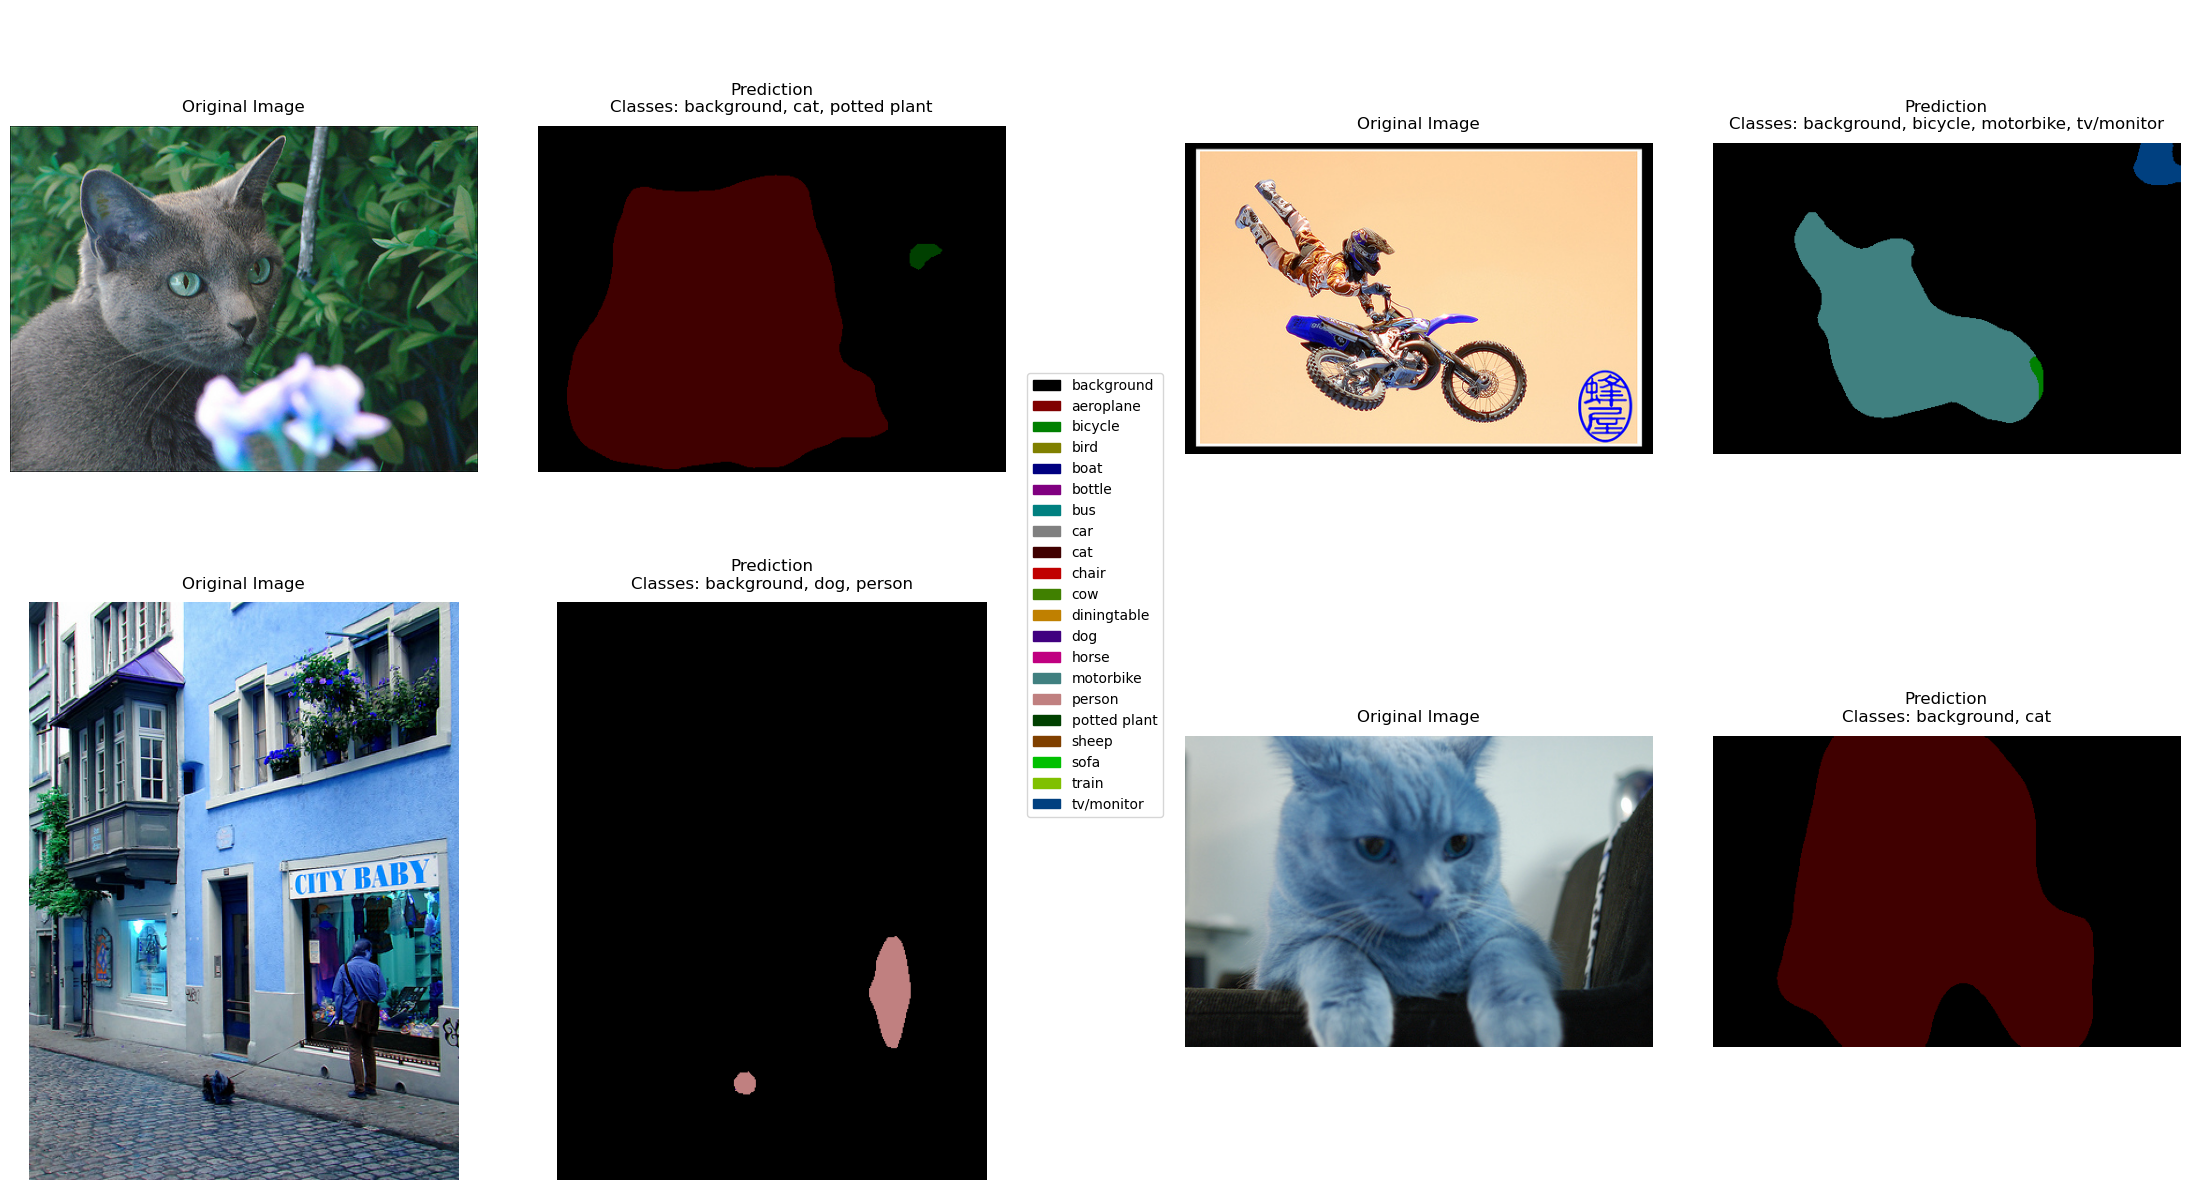

In [73]:
from matplotlib import patches

# Function to preprocess an image


def preprocess_image(image_path):
    img = cv2.imread(image_path).astype(float)
    img[:, :, 0] -= 104.008
    img[:, :, 1] -= 116.669
    img[:, :, 2] -= 122.675
    img = torch.from_numpy(img.transpose((2, 0, 1))).float().to(device).unsqueeze(0)
    return img


# Define class names
CLASS_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
    'bus', 'car', 'cat', 'chair', 'cow',
    'diningtable', 'dog', 'horse', 'motorbike', 'person',
    'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor'
]

# Function to get unique classes in prediction


def get_unique_classes(prediction):
    return np.unique(prediction)


# List of image paths (replace with your actual image paths)
image_paths = [
    'lab4/img/2009_005160.jpg',
    'lab4/img/2009_004987.jpg',
    'lab4/img/2009_004645.jpg',
    'lab4/img/2009_004607.jpg'
]

# Create figure with extra space for legend
fig = plt.figure(figsize=(22, 12))
gs = plt.GridSpec(2, 5, width_ratios=[4, 4, 0.5, 4, 4])

# Load and preprocess images
test_convs = [preprocess_image(path) for path in image_paths]

for i, test_conv in enumerate(test_convs):
    row = i // 2
    col = (i % 2) * 3  # Skip the middle column for legend

    with torch.no_grad():
        conv_out = model(test_conv)
    output = torch.argmax(conv_out, dim=1)
    prediction = output[0].data.cpu().numpy()
    vis_output = decode_labels(prediction)

    # Plot original image
    ax_orig = fig.add_subplot(gs[row, col])
    original_img = test_conv[0].data.cpu().numpy().transpose((1, 2, 0))
    original_img[:, :, 0] += 104.008
    original_img[:, :, 1] += 116.669
    original_img[:, :, 2] += 122.675
    original_img = original_img.astype(np.uint8)
    ax_orig.imshow(original_img)
    ax_orig.axis('off')
    ax_orig.set_title('Original Image', pad=10)

    # Plot predicted image
    ax_pred = fig.add_subplot(gs[row, col + 1])
    ax_pred.imshow(vis_output)
    ax_pred.axis('off')

    # Get unique classes in this prediction and create title
    unique_classes = get_unique_classes(prediction)
    class_names = [CLASS_NAMES[idx] for idx in unique_classes]
    title = 'Prediction\nClasses: ' + ', '.join(class_names)
    ax_pred.set_title(title, pad=10)

    # Add legend in the middle column for first row only
    if i == 0:
        ax_legend = fig.add_subplot(gs[:, 2])
        legend_elements = []

        # Create color patches for all possible classes
        label_colours = [(0, 0, 0), (128, 0, 0), (0, 128, 0), (128, 128, 0),
                         (0, 0, 128), (128, 0, 128), (0, 128, 128), (128, 128, 128),
                         (64, 0, 0), (192, 0, 0), (64, 128, 0), (192, 128, 0),
                         (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
                         (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0),
                         (0, 64, 128)]

        for idx, (name, color) in enumerate(zip(CLASS_NAMES, label_colours)):
            color_rgb = [x/255.0 for x in color]  # Convert to RGB (0-1)
            patch = patches.Patch(color=color_rgb, label=name)
            legend_elements.append(patch)

        ax_legend.legend(handles=legend_elements, loc='center', bbox_to_anchor=(0.5, 0.5))
        ax_legend.axis('off')

plt.tight_layout()

fig.savefig('lab4/inference.pdf')
plt.show()

### *References*
[1] FCN official code (https://github.com/shelhamer/fcn.berkeleyvision.org)

[2] Upsampling method (https://towardsdatascience.com/types-of-convolutions-in-deep-learning-717013397f4d)

[3] Cs231n (http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture11.pdf)